In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [ ]:
def get_classifier(neighbors,training_data,training_labels):
    # Input integer number of neighbors, training data, and training labels
    # Ouput the classifier object
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    
    classifier = neigh.fit(training_data,training_labels)
    return classifier

def get_tests(neighbors,training_data,training_labels,GalType):
    # Get the classifier
    classifier = get_classifier(neighbors,training_data,training_labels)
    
    # Predict what galaxy type each object should be
    predict_labels = classifier.predict(data[half:])
    
    # Assess what is classified correctly
    true_labels = predict_labels[predict_labels == df["Type"][half:]]
    false_labels = predict_labels[predict_labels != df["Type"][half:]]
    
    # Calculate Completeness and Purity
    TruePositive = len(true_labels[true_labels == GalType])
    FalseNegative = len(false_labels[false_labels != GalType])
    FalsePositive = len(false_labels[false_labels == GalType])
    
    Completeness = TruePositive / (TruePositive + FalseNegative)
    Purity = TruePositive / (TruePositive + FalsePositive)
    
    return Completeness, Purity 

## Import data and reduce as needed.

In [5]:
df = pd.read_csv("../DataSet/Merged_Reduced_SDSS_GZ_Catalog.csv")
# Drop unknowns
df = df.drop(df[df["P_DK"]>0.5].index)
df = df.drop(df[np.isnan(df["dered_g"])].index)
df = df.drop(df[np.isnan(df["dered_r"])].index)
df = df.drop(df[np.isnan(df["dered_i"])].index)
df.reset_index()
conditions = [(df["P_EL"] > df["P_CS"]), (df["P_EL"] < df["P_CS"])]
cases = ["Elliptical","Spiral"]
df["Type"] = np.select(conditions,cases,default="Unknown")
df["dered_g-dered_r"] = df["dered_g"] - df["dered_r"]
df["dered_r-dered_i"] = df["dered_r"] - df["dered_i"]
df.to_csv("../DataSet/GalaxyZooSDSSDataset.csv")

## Choose what parameter space you want to work in.

In [3]:
X = "dered_g-dered_r"; Y = "dered_g"

## Format the full data, training data, and test data

In [ ]:
data = np.zeros([len(df[X]),2]); data[:,0] = df[X]; data[:,1] = df[Y]

I split the full data in half here, but there's fancier ways to do this using KFOLD. 

In [4]:
half = int(np.ceil(len(df[X])/2))
training_data = np.zeros([half,2]); training_data[:,0] = df[X][0:half]
training_data[:,1] = np.array(df[Y][0:half]); training_labels = df.Type[0:half]

Get some classifier just to see one result.

In [5]:
classifier = get_classifier(5)

Create coordinates for the entire parameter space and predict labels for each point. 

In [6]:
x,y = np.meshgrid(np.arange(min(df[X]),max(df[X]),0.1),np.arange(min(df[Y]),max(df[Y]),.1))
test_data = np.zeros([len(x.flatten()),2]); test_data[:,0] = x.flatten(); test_data[:,1] = y.flatten()
test_labels = classifier.predict(test_data)

new_dict = {X:test_data[:,0],Y:test_data[:,1],"Type":test_labels}
tr = pd.DataFrame.from_dict(new_dict)

<Figure size 432x288 with 0 Axes>

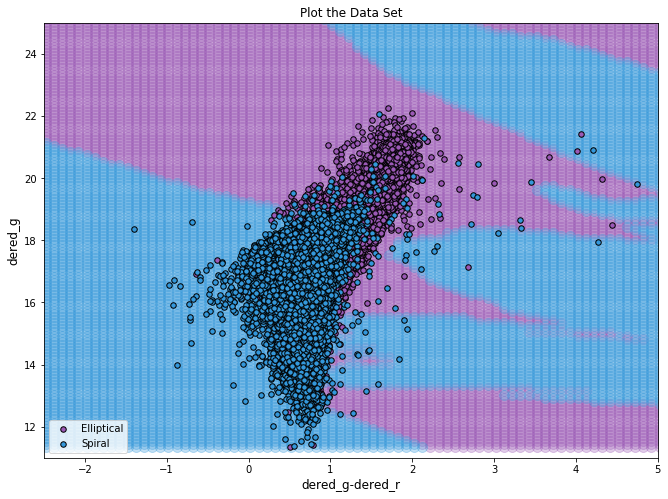

In [61]:
plt.clf(); 
plt.figure(figsize=(11,8))

plt.scatter(tr[X].loc[tr["Type"]=="Elliptical"],tr[Y].loc[tr["Type"]=="Elliptical"],c="#9b59b6",alpha=0.3,zorder=0,s=100,label="")
plt.scatter(tr[X].loc[tr["Type"]=="Spiral"],tr[Y].loc[tr["Type"]=="Spiral"],c="#3498db",alpha=0.3,zorder=0,s=100,label="")

plt.scatter(df[X].loc[df["Type"]=="Elliptical"],df[Y].loc[df["Type"]=="Elliptical"],c="#9b59b6",edgecolor="black",label="Elliptical",s=30,zorder=2)
plt.scatter(df[X].loc[df["Type"]=="Spiral"],df[Y].loc[df["Type"]=="Spiral"],c="#3498db",edgecolor="black",label="Spiral",s=30,zorder=2)

plt.xlim(-2.5,5); plt.ylim(11,25)
plt.legend(); plt.xlabel(X,size="large"); plt.ylabel(Y,size="large")
plt.title("Plot the Data Set")
plt.savefig("DataSet.png")
plt.show()

## Test for completeness and Purity

In [53]:
E_Tests = np.array([get_tests(i,"Elliptical") for i in range(1,20)])
S_Tests = np.array([get_tests(i,"Spiral") for i in range(1,20)])

<Figure size 432x288 with 0 Axes>

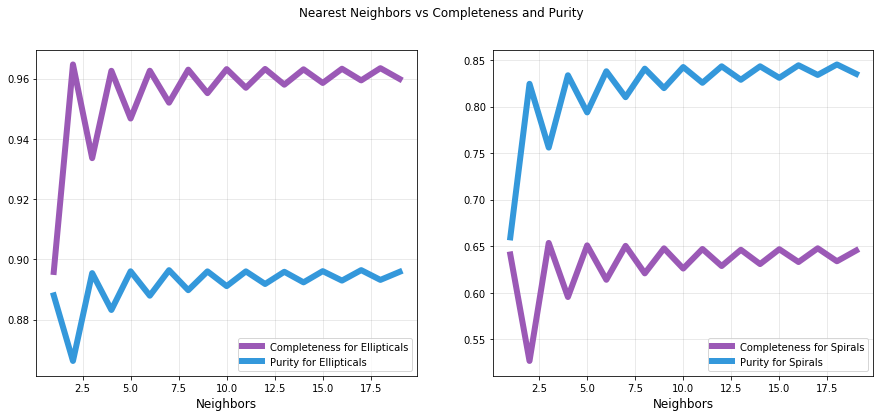

In [60]:
plt.clf()
f, (ax,bx) = plt.subplots(1,2,figsize=(15,6))
ax.plot(np.arange(1,20),E_Tests[:,0],label="Completeness for Ellipticals",c="#9b59b6",linewidth=6)
ax.plot(np.arange(1,20),E_Tests[:,1],label="Purity for Ellipticals",c="#3498db",linewidth=6)
ax.legend(); ax.set_xlabel("Neighbors",size="large")
bx.plot(np.arange(1,20),S_Tests[:,0],label="Completeness for Spirals",c="#9b59b6",linewidth=6)
bx.plot(np.arange(1,20),S_Tests[:,1],label="Purity for Spirals",c="#3498db",linewidth=6)
bx.legend(); bx.set_xlabel("Neighbors",size="large")
f.suptitle("Nearest Neighbors vs Completeness and Purity")
ax.grid(color="grey",alpha=0.2); bx.grid(color="grey",alpha=0.2)
plt.savefig("NearestNeighborsvsCompletenessandPurity.png")
plt.show()

<Figure size 432x288 with 0 Axes>

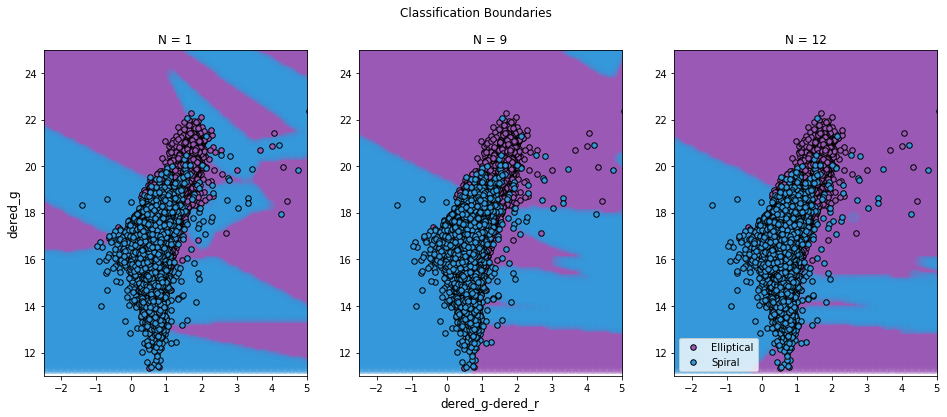

In [59]:
plt.clf(); 
f, (ax,bx,cx) = plt.subplots(1,3,figsize=(16,6))

tr1_labels = get_classifier(1).predict(test_data)
tr1 = pd.DataFrame.from_dict({X:test_data[:,0],Y:test_data[:,1],"Type":tr1_labels})

ax.scatter(tr[X].loc[tr1["Type"]=="Elliptical"],tr[Y].loc[tr1["Type"]=="Elliptical"],c="#9b59b6",alpha=0.3,zorder=0,s=100,label="")
ax.scatter(tr[X].loc[tr1["Type"]=="Spiral"],tr[Y].loc[tr1["Type"]=="Spiral"],c="#3498db",alpha=0.3,zorder=0,s=100,label="")
ax.scatter(df[X].loc[df["Type"]=="Elliptical"],df[Y].loc[df["Type"]=="Elliptical"],c="#9b59b6",edgecolor="black",label="Elliptical",s=30,zorder=2)
ax.scatter(df[X].loc[df["Type"]=="Spiral"],df[Y].loc[df["Type"]=="Spiral"],c="#3498db",edgecolor="black",label="Spiral",s=30,zorder=2)

tr2_labels = get_classifier(9).predict(test_data)
tr2 = pd.DataFrame.from_dict({X:test_data[:,0],Y:test_data[:,1],"Type":tr2_labels})
bx.scatter(tr[X].loc[tr2["Type"]=="Elliptical"],tr[Y].loc[tr2["Type"]=="Elliptical"],c="#9b59b6",alpha=0.3,zorder=0,s=100,label="")
bx.scatter(tr[X].loc[tr2["Type"]=="Spiral"],tr[Y].loc[tr2["Type"]=="Spiral"],c="#3498db",alpha=0.3,zorder=0,s=100,label="")
bx.scatter(df[X].loc[df["Type"]=="Elliptical"],df[Y].loc[df["Type"]=="Elliptical"],c="#9b59b6",edgecolor="black",label="Elliptical",s=30,zorder=2)
bx.scatter(df[X].loc[df["Type"]=="Spiral"],df[Y].loc[df["Type"]=="Spiral"],c="#3498db",edgecolor="black",label="Spiral",s=30,zorder=2)

tr3_labels = get_classifier(12).predict(test_data)
tr3 = pd.DataFrame.from_dict({X:test_data[:,0],Y:test_data[:,1],"Type":tr3_labels})
cx.scatter(tr[X].loc[tr3["Type"]=="Elliptical"],tr[Y].loc[tr3["Type"]=="Elliptical"],c="#9b59b6",alpha=0.3,zorder=0,s=100,label="")
cx.scatter(tr[X].loc[tr3["Type"]=="Spiral"],tr[Y].loc[tr3["Type"]=="Spiral"],c="#3498db",alpha=0.3,zorder=0,s=100,label="")
cx.scatter(df[X].loc[df["Type"]=="Elliptical"],df[Y].loc[df["Type"]=="Elliptical"],c="#9b59b6",edgecolor="black",label="Elliptical",s=30,zorder=2)
cx.scatter(df[X].loc[df["Type"]=="Spiral"],df[Y].loc[df["Type"]=="Spiral"],c="#3498db",edgecolor="black",label="Spiral",s=30,zorder=2)

ax.set_xlim(-2.5,5); ax.set_ylim(11,25)
bx.set_xlim(-2.5,5); bx.set_ylim(11,25)
cx.set_xlim(-2.5,5); cx.set_ylim(11,25)
ax.set_title("N = 1");bx.set_title("N = 9");cx.set_title("N = 12")
plt.legend(); bx.set_xlabel(X,size="large"); ax.set_ylabel(Y,size="large")
f.suptitle("Classification Boundaries")
plt.savefig("ClassificationBoundaries.png")
plt.show()